In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re

from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.utils.multiclass import unique_labels

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

## Exploratory Data Analysis and Preproccessing

In [33]:
# import tweets
tweets = pd.read_csv("../data/Tweets_historical/historic_tweets_official_07242019.csv")

In [34]:
tweets.head()

,date,geo,hashtags,id,text,type,username
0,2016-11-29 14:33:36+00:00,NaN,NaN,803607850178269185,Douglas County Crash - EB I-20 b4 Post Rd (exi...,official,GDOTATL
1,2016-11-28 20:35:05+00:00,NaN,#ArriveAliveGApic,803336433155108864,With rain on the way - we have an important me...,official,GDOTATL
2,2016-11-28 19:02:02+00:00,NaN,#DAAA #ArriveAliveGApic,803313015500263425,Much needed rain is headed our way... please b...,official,GDOTATL
3,2016-11-28 14:31:55+00:00,NaN,NaN,803245038100586496,Fulton County - Crash EB SR 14 at MP 12.64 (SR...,official,GDOTATL
4,2016-11-24 19:01:16+00:00,NaN,#Thanksgivingpic,801863271821275140,Happy Thanksgiving! Please drive safe and pati...,official,GDOTATL


In [35]:
# define function to plot count of words after count vectorization
# Code modified from http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
def bar_plot(x, y, title, color):    
    
    # Set up barplot 
    plt.figure(figsize=(8,4))
    ax = sns.barplot(x, y, color = color)

    # Label the graph
    plt.title(title, fontsize = 15)
    plt.xticks(fontsize = 10)

    # create a list to collect the plt.patches data
    totals = []

    # set individual bar lables using above list
    for p in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(p.get_width()+.3, p.get_y()+.38,
                int(p.get_width()), fontsize=10)

In [36]:
# define function to run regex startments over a column labeled "text"
def twt_preprocess(twt):
    # run regex to remove urls
    twt['text'] = twt['text'].map(lambda x: re.sub(r"((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?", ' ', x))

    # run regex to remove non alphanumeric characters
    twt['text'] = twt['text'].map(lambda x: re.sub(r"[@\?\.$%_\!\[\]()+:;\/*\"]", ' ', x, flags=re.I))

    # run regex to remove common words
    twt['text'] = twt['text'].map(lambda x: re.sub('(twitter|tweet)[s]?', ' ', x,  flags=re.I))   
    

In [37]:
# run regex cleaner on full dataframe
twt_preprocess(tweets)

#### Create Dataframe of Tweets that mention keywords related to road closures

In [38]:
# establish list of words to search for in dataframe
closed_keywords = ['road closed', 'remains closed', 'closed',
                   'no travel', 'delay', 'lane', 
                   'disabled', 'traffic']

to_drop = ["open", "opened", "lifted", "plane", "reopened", "clear", "cleared"]

In [39]:
# define function to filter the full dataframe for tweets that contain words from a keyword list
def tweet_filter (df, col, keywords, dropwords=None):
    
    query = []
    
    # populate query list with masks that test if a word is in datafram
    for word in keywords:
        mask = df[col].str.contains(word, regex=False, case=False)
        query.append(mask)
        
    # run filter, specifying ANY text
    filter_df = df[np.any(query, axis=0)]
    
    # test words to drop functionality
    if dropwords is not None:
        
        # drop words in drop words list
        return filter_df[~filter_df[col].str.contains('|'.join(dropwords))]
    
    else:
        return filter_df

In [40]:
# run function on full dataframe
closed = tweet_filter(tweets, 'text', closed_keywords, to_drop)

# backup original tweet to new dataframe
closed['tweet'] = closed['text']

In [41]:
# Create target variable 
closed['road_closure'] = 1
closed.head()

,date,geo,hashtags,id,text,type,username,tweet,road_closure
3,2016-11-28 14:31:55+00:00,NaN,NaN,803245038100586496,Fulton County - Crash EB SR 14 at MP SR 29 ...,official,GDOTATL,Fulton County - Crash EB SR 14 at MP SR 29 ...,1
9,2016-11-21 23:15:13+00:00,NaN,NaN,800840017014849538,The Georgia Department of Transportation is su...,official,GDOTATL,The Georgia Department of Transportation is su...,1
10,2016-11-20 17:13:30+00:00,NaN,NaN,800386599460728832,FULTON COUNTY VEHICLE FIRE NB I-285 AFTER BO...,official,GDOTATL,FULTON COUNTY VEHICLE FIRE NB I-285 AFTER BO...,1
17,2016-11-17 23:15:12+00:00,NaN,NaN,799390459290324993,Daytime traffic pace for rock blasting will af...,official,GDOTATL,Daytime traffic pace for rock blasting will af...,1
22,2016-11-15 23:10:12+00:00,NaN,#GAExpressLanes,798664428279517184,HOW IT WORKS Warning gates will direct traffi...,official,GDOTATL,HOW IT WORKS Warning gates will direct traffi...,1


In [42]:
# find which accounts had information about road closures
closed['username'].value_counts()

fl511_southwest    2907
fl511_tampabay     2876
fl511_state        2740
fl511_central      2716
fl511_southeast    2641
511northernva      2633
511statewideva     2488
511centralva       2324
511hamptonroads    2069
fl511_northeast    1947
NCDOT_Triangle     1787
fl511_panhandl      803
NCDOT_Scoast        546
NCDOT_Charlotte     540
NCDOT_Ncoast        460
511Georgia          262
SCDOTLowCountry     240
NCDOT_Asheville     236
SCDOTPiedmont       128
SCDOTMidlands       118
NCDOT_Piedmont      100
SCDOTPeeDee          61
NCDOT_Westmtn        21
GDOTATL              20
Name: username, dtype: int64

In [43]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(closed['text'])

# Convert cvec into a DataFrame
tweets_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(tweets_cvec.shape)

(30663, 3672)


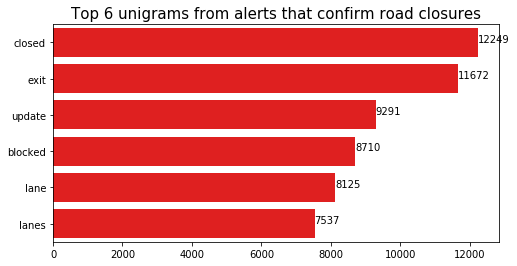

In [44]:
# Set up variables to contain top 5 most used words 
wc1_tweets_cvec = tweets_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(wc1_tweets_cvec.values, wc1_tweets_cvec.index, 'Top 6 unigrams from alerts that confirm road closures','r')

#### Create Dataframe of Tweets that do not mention closures

In [45]:
# Get index number of tweets identified as road closures 
closed_index = list(closed.index)

# Remove all road closure tweets from full dataframe
tweets_open = tweets.drop(closed_index)

# Drop any instances where false positives might occur
tweets_open = tweets_open[~tweets_open.text.str.contains("remains closed")]
tweets_open = tweets_open[~tweets_open.text.str.contains("remains close")]

# Shape
tweets_open.shape

(12353, 7)

In [46]:
# To maintain balanced classes, drop rows in `tweets_open` so that they are equal to `closed`
tweets_open = tweets_open.iloc[0:(closed.shape[0])]

# backup original tweet to new dataframe
tweets_open['tweet'] = tweets_open['text']
tweets_open.shape

(12353, 8)

In [47]:
# Create target variable 
tweets_open['road_closure'] = 0
tweets_open.head()

,date,geo,hashtags,id,text,type,username,tweet,road_closure
0,2016-11-29 14:33:36+00:00,NaN,NaN,803607850178269185,Douglas County Crash - EB I-20 b4 Post Rd exi...,official,GDOTATL,Douglas County Crash - EB I-20 b4 Post Rd exi...,0
1,2016-11-28 20:35:05+00:00,NaN,#ArriveAliveGApic,803336433155108864,With rain on the way - we have an important me...,official,GDOTATL,With rain on the way - we have an important me...,0
2,2016-11-28 19:02:02+00:00,NaN,#DAAA #ArriveAliveGApic,803313015500263425,Much needed rain is headed our way please b...,official,GDOTATL,Much needed rain is headed our way please b...,0
4,2016-11-24 19:01:16+00:00,NaN,#Thanksgivingpic,801863271821275140,Happy Thanksgiving Please drive safe and pati...,official,GDOTATL,Happy Thanksgiving Please drive safe and pati...,0
5,2016-11-24 01:00:30+00:00,NaN,#Thanksgivingpic,801591286889332736,Have a safe Thanksgiving Put away your cell p...,official,GDOTATL,Have a safe Thanksgiving Put away your cell p...,0


In [48]:
# Instantiate a CountVectorizer
cv = CountVectorizer(stop_words = 'english')

# Fit and transform the vectorizer on our corpus
cvec = cv.fit_transform(tweets_open['text'])

# Convert cvec into a DataFrame
tweets_cvec = pd.DataFrame(cvec.toarray(),
                   columns=cv.get_feature_names())

# Inspect new DF
print(tweets_cvec.shape)

(12353, 3261)


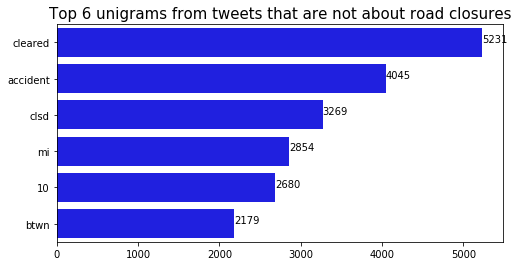

In [49]:
# Set up variables to contain top 5 most used words 
wc1_tweets_cvec = tweets_cvec.sum(axis = 0).sort_values(ascending=False).head(6)

# Call bar plot function
bar_plot(wc1_tweets_cvec.values, wc1_tweets_cvec.index, 'Top 6 unigrams from tweets that are not about road closures','b')

#### Create Training Dataframe

In [50]:
# Merge dataframes
tweets_training = pd.concat([tweets_open, closed], axis=0)
tweets_training.shape

(43016, 9)

In [51]:
tweets_training.head()

,date,geo,hashtags,id,text,type,username,tweet,road_closure
0,2016-11-29 14:33:36+00:00,NaN,NaN,803607850178269185,Douglas County Crash - EB I-20 b4 Post Rd exi...,official,GDOTATL,Douglas County Crash - EB I-20 b4 Post Rd exi...,0
1,2016-11-28 20:35:05+00:00,NaN,#ArriveAliveGApic,803336433155108864,With rain on the way - we have an important me...,official,GDOTATL,With rain on the way - we have an important me...,0
2,2016-11-28 19:02:02+00:00,NaN,#DAAA #ArriveAliveGApic,803313015500263425,Much needed rain is headed our way please b...,official,GDOTATL,Much needed rain is headed our way please b...,0
4,2016-11-24 19:01:16+00:00,NaN,#Thanksgivingpic,801863271821275140,Happy Thanksgiving Please drive safe and pati...,official,GDOTATL,Happy Thanksgiving Please drive safe and pati...,0
5,2016-11-24 01:00:30+00:00,NaN,#Thanksgivingpic,801591286889332736,Have a safe Thanksgiving Put away your cell p...,official,GDOTATL,Have a safe Thanksgiving Put away your cell p...,0


## Modeling

In [52]:
# Baseline score
tweets_training['road_closure'].value_counts(normalize=True)

1    0.712828
0    0.287172
Name: road_closure, dtype: float64

In [53]:
# define our variables
X = tweets_training['text']
y = tweets_training['road_closure']

In [54]:
# train test split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    stratify=y)

In [55]:
pipe = Pipeline([('cvec', CountVectorizer()),    
                 ('lr', LogisticRegression(solver='liblinear'))])

# Tune GridSearchCV
pipe_params = {'cvec__stop_words': [None, 'english'],
               'cvec__ngram_range': [(1,1), (2,2), (1,3)],
               'lr__C': [0.01, 1]}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X_train, y_train))
print("Test score", gs.score(X_test, y_test))

gs.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    7.7s finished


Best score: 0.999101109664621
Train score 0.9995970491600025
Test score 0.9991631021015436


{'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'lr__C': 1}

In [56]:
#Instantiate the classifier and vectorizer
lr = LogisticRegression(C = 1.0, solver='liblinear')
cvec = CountVectorizer(ngram_range=(1, 3), stop_words= 'english')

# Fit and transform the vectorizor
cvec.fit(X_train)

cvec_train = cvec.transform(X_train)
cvec_test = cvec.transform(X_test)

# Fit the classifier
lr.fit(cvec_train,y_train)

# Create the predictions for Y training data
y_pred = lr.predict(cvec_test)

print(f'Train Score: {lr.score(cvec_train, y_train)}')
print(f'Test Score: {lr.score(cvec_test, y_test)}')

Train Score: 0.9998450189076933
Test Score: 0.9986981588246234


In [57]:
# function to visualize confusion matrix
# Source code from SkLearn documentation
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[3082    6]
 [   8 7658]]


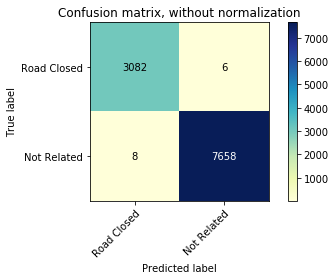

In [58]:
# set decimal places for numpy functions
np.set_printoptions(precision=2)

#define class names
class_names=np.array(['Road Closed', 'Not Related'])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization',
                     cmap='YlGnBu')


plt.show();

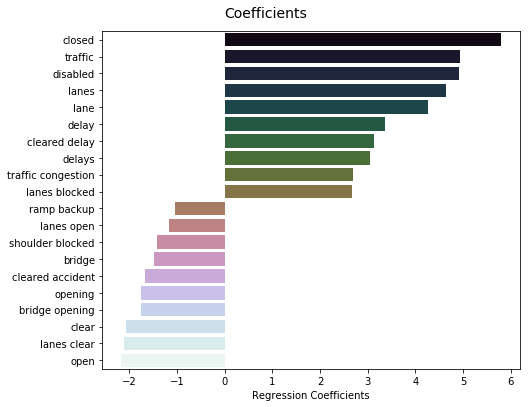

In [59]:
# Create list of logistic regression coefficients 
lr_coef = np.array(lr.coef_).tolist()
lr_coef = lr_coef[0]

# create dataframe from lasso coef
lr_coef = pd.DataFrame(np.round_(lr_coef, decimals=3), 
cvec.get_feature_names(), columns = ["lr_coef"])

# sort the values from high to low
lr_coef = lr_coef.sort_values(by = 'lr_coef', 
ascending = False)

# Create top and bottom 10 
df_head = lr_coef.head(10)
df_tail = lr_coef.tail(10)

# merge back together
df_merged = pd.concat([df_head, df_tail], axis=0)

# plot the sorted dataframe
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.suptitle('Coefficients', size=14)
ax = sns.barplot(x = 'lr_coef', y= df_merged.index, 
data=df_merged, palette= 'cubehelix')
ax.set(xlabel='Regression Coefficients')
plt.tight_layout(pad=3, w_pad=0, h_pad=0);

In [60]:
tweets_training.head()

,date,geo,hashtags,id,text,type,username,tweet,road_closure
0,2016-11-29 14:33:36+00:00,NaN,NaN,803607850178269185,Douglas County Crash - EB I-20 b4 Post Rd exi...,official,GDOTATL,Douglas County Crash - EB I-20 b4 Post Rd exi...,0
1,2016-11-28 20:35:05+00:00,NaN,#ArriveAliveGApic,803336433155108864,With rain on the way - we have an important me...,official,GDOTATL,With rain on the way - we have an important me...,0
2,2016-11-28 19:02:02+00:00,NaN,#DAAA #ArriveAliveGApic,803313015500263425,Much needed rain is headed our way please b...,official,GDOTATL,Much needed rain is headed our way please b...,0
4,2016-11-24 19:01:16+00:00,NaN,#Thanksgivingpic,801863271821275140,Happy Thanksgiving Please drive safe and pati...,official,GDOTATL,Happy Thanksgiving Please drive safe and pati...,0
5,2016-11-24 01:00:30+00:00,NaN,#Thanksgivingpic,801591286889332736,Have a safe Thanksgiving Put away your cell p...,official,GDOTATL,Have a safe Thanksgiving Put away your cell p...,0


In [61]:
tweets_training.to_csv('../data/cleaned_tweets/cleaned_historic_official_07242019.csv', index = False)